In [1]:
import os

# Paths
image_dir = r"C:/Users/victo/Downloads/dental-cepha-dataset/dental-cepha-dataset/"
doctor1_dir = os.path.join(image_dir, "doctor1")
doctor2_dir = os.path.join(image_dir, "doctor2")

# List BMP and TXT files
images = [f for f in os.listdir(image_dir) if f.lower().endswith(".bmp")]
doctor1_files = [f for f in os.listdir(doctor1_dir) if f.lower().endswith(".txt")]
doctor2_files = [f for f in os.listdir(doctor2_dir) if f.lower().endswith(".txt")]

print(f"Number of images: {len(images)}")
print(f"Doctor1 annotations: {len(doctor1_files)}")
print(f"Doctor2 annotations: {len(doctor2_files)}")

# Check correspondence
missing_doctor1 = [img for img in images if os.path.splitext(img)[0] + ".txt" not in doctor1_files]
missing_doctor2 = [img for img in images if os.path.splitext(img)[0] + ".txt" not in doctor2_files]

print(f"Images missing doctor1 annotations: {len(missing_doctor1)}")
print(f"Images missing doctor2 annotations: {len(missing_doctor2)}")

# Count annotation points
def count_points(txt_path):
    with open(txt_path, "r") as f:
        lines = f.readlines()
    return len(lines)

total_points_doc1 = sum(count_points(os.path.join(doctor1_dir, f)) for f in doctor1_files)
total_points_doc2 = sum(count_points(os.path.join(doctor2_dir, f)) for f in doctor2_files)

print(f"Total annotation points (Doctor1): {total_points_doc1}")
print(f"Total annotation points (Doctor2): {total_points_doc2}")

Number of images: 0
Doctor1 annotations: 102
Doctor2 annotations: 102
Images missing doctor1 annotations: 0
Images missing doctor2 annotations: 0
Total annotation points (Doctor1): 1938
Total annotation points (Doctor2): 1938


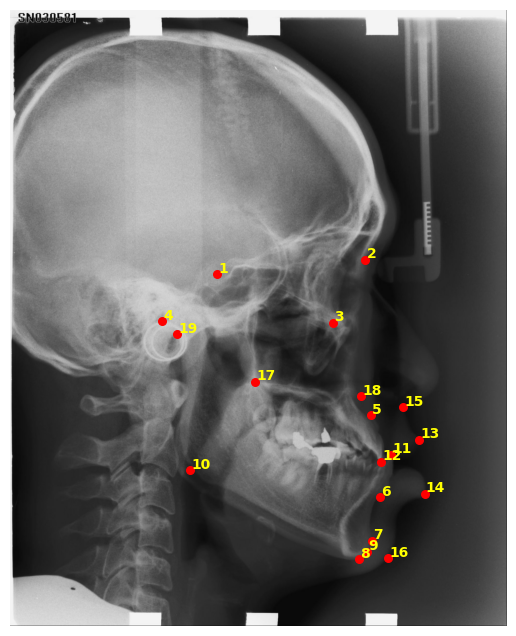

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Paths
image_dir = r"C:\Users\victo\Downloads\OneDrive_2025-09-23\Dataset Kaggle\Dataset Kaggle\cepha400\cepha400"
csv_path = r"C:\Users\victo\Downloads\OneDrive_2025-09-23\Dataset Kaggle\Dataset Kaggle\train_senior.csv"

# Load CSV
df = pd.read_csv(csv_path)

# Select one image (example: 017.jpg)
image_name = "017.jpg"
row = df[df["image_path"] == image_name].iloc[0]

# Read image
img_path = os.path.join(image_dir, image_name)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR→RGB for matplotlib

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")

# Extract landmarks (1–19)
for i in range(1, 20):
    x = int(row[f"{i}_x"])
    y = int(row[f"{i}_y"])
    plt.scatter(x, y, c="red", s=30)
    plt.text(x + 5, y - 5, str(i), color="yellow", fontsize=10, weight="bold")

plt.show()

In [3]:
import os
import json
import shutil
from datetime import datetime
from pathlib import Path
import pandas as pd  # For displaying summary statistics

# %% [markdown]
# ## 2. Define Landmark Mapping

# %%
# Define the landmark mapping (order in txt file -> landmark info)
LANDMARK_MAPPING = [
    {"title": "Sella", "symbol": "S"},
    {"title": "Nasion", "symbol": "N"},
    {"title": "Orbitale", "symbol": "Or"},
    {"title": "Porion", "symbol": "Po"},
    {"title": "Anterior Nasal Spine", "symbol": "ANS"},
    {"title": "Posterior Nasal Spine", "symbol": "PNS"},
    {"title": "A-point", "symbol": "A"},
    {"title": "B-point", "symbol": "B"},
    {"title": "Pogonion", "symbol": "Pog"},
    {"title": "Menton", "symbol": "Me"},
    {"title": "Gnathion", "symbol": "Gn"},
    {"title": "Gonion", "symbol": "Go"},
    {"title": "Articulare", "symbol": "Ar"},
    {"title": "Lower Incisor Tip", "symbol": "LIT"},
    {"title": "Upper Incisor Tip", "symbol": "UIT"},
    {"title": "Soft Tissue Pogonion", "symbol": "Pos"},
    {"title": "Subnasale", "symbol": "Sn"},
    {"title": "Labrale superius", "symbol": "Ls"},
    {"title": "Labrale inferius", "symbol": "Li"}
]

# Display the mapping
print("Landmark Mapping (Order in TXT file):")
print("=" * 50)
for i, landmark in enumerate(LANDMARK_MAPPING, 1):
    print(f"{i:2d}. {landmark['symbol']:3s} - {landmark['title']}")

# %% [markdown]
# ## 3. Define Helper Functions

# %%
def generate_ceph_id(file_number, doctor_number):
    """Generate a unique ceph_id for each annotation"""
    return f"ceph_doc{doctor_number}_img{file_number}_{datetime.now().strftime('%Y%m%d%H%M%S')}"

def read_txt_landmarks(txt_path):
    """Read landmarks from txt file"""
    landmarks = []
    with open(txt_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.strip():
                x, y = line.strip().split(',')
                landmarks.append((int(x), int(y)))
    return landmarks

def convert_to_json_format(landmarks, file_number, doctor_number):
    """Convert landmarks to the required JSON format"""
    json_data = {
        "ceph_id": generate_ceph_id(file_number, doctor_number),
        "landmarks": [],
        "reviewed_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S.000000"),
        "updated_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S.000000"),
        "dataset_name": "CEPHA29: Cephalometric Landmark Detection Dataset",
        "open_issues": 0
    }
    
    # Map each landmark with its corresponding name and symbol
    for i, (x, y) in enumerate(landmarks):
        if i < len(LANDMARK_MAPPING):
            landmark_info = LANDMARK_MAPPING[i]
            json_data["landmarks"].append({
                "title": landmark_info["title"],
                "symbol": landmark_info["symbol"],
                "value": {
                    "x": x,
                    "y": y
                }
            })
    
    return json_data

# %% [markdown]
# ## 4. Define Processing Functions

# %%
def process_directory(source_dir, output_dir, doctor_number):
    """Process all txt files in a directory and convert to JSON"""
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Get all txt files
    txt_files = [f for f in os.listdir(source_dir) if f.endswith('.txt')]
    
    results = []
    converted_count = 0
    
    for txt_file in txt_files:
        try:
            # Get file number (remove .txt extension)
            file_number = txt_file.replace('.txt', '')
            
            # Read landmarks from txt file
            txt_path = os.path.join(source_dir, txt_file)
            landmarks = read_txt_landmarks(txt_path)
            
            # Convert to JSON format
            json_data = convert_to_json_format(landmarks, file_number, doctor_number)
            
            # Save JSON file
            json_filename = f"{file_number}.json"
            json_path = os.path.join(output_dir, json_filename)
            
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(json_data, f, indent=2, ensure_ascii=False)
            
            converted_count += 1
            results.append({
                'file': txt_file,
                'status': 'Success',
                'landmarks_count': len(landmarks),
                'output': json_filename
            })
            
        except Exception as e:
            results.append({
                'file': txt_file,
                'status': 'Failed',
                'landmarks_count': 0,
                'output': f"Error: {str(e)}"
            })
    
    return converted_count, results

def copy_images(source_image_dir, output_image_dir):
    """Copy image files to the new directory structure"""
    Path(output_image_dir).mkdir(parents=True, exist_ok=True)
    
    # Copy all BMP files
    bmp_files = [f for f in os.listdir(source_image_dir) if f.endswith('.bmp') or f.endswith('.BMP')]
    
    copied_files = []
    for bmp_file in bmp_files:
        source_path = os.path.join(source_image_dir, bmp_file)
        dest_path = os.path.join(output_image_dir, bmp_file)
        shutil.copy2(source_path, dest_path)
        copied_files.append(bmp_file)
    
    return len(bmp_files), copied_files

# %% [markdown]
# ## 5. Set Up Paths

# %%
# Define paths
base_path = r"C:\Users\victo\Downloads\dental-cepha-dataset\dental-cepha-dataset"

# Source directories
image_dir = os.path.join(base_path, "image")
doctor1_dir = os.path.join(base_path, "doctor1")
doctor2_dir = os.path.join(base_path, "doctor2")

# Output base directory (create a copy with _json suffix)
output_base = base_path + "_json"

# Output directories
output_image_dir = os.path.join(output_base, "image")
output_doctor1_dir = os.path.join(output_base, "doctor1")
output_doctor2_dir = os.path.join(output_base, "doctor2")

print("Configuration:")
print("=" * 60)
print(f"Source directory: {base_path}")
print(f"Output directory: {output_base}")
print("=" * 60)

# %% [markdown]
# ## 6. Check Source Directories

# %%
# Check if directories exist
directories_status = []

for name, path in [("Base", base_path), 
                   ("Images", image_dir), 
                   ("Doctor1", doctor1_dir), 
                   ("Doctor2", doctor2_dir)]:
    exists = os.path.exists(path)
    directories_status.append({
        'Directory': name,
        'Path': path,
        'Exists': '✓' if exists else '✗'
    })
    
status_df = pd.DataFrame(directories_status)
print("Directory Status:")
print(status_df.to_string(index=False))

# %% [markdown]
# ## 7. Copy Images

# %%
print("\n" + "=" * 60)
print("STEP 1: Copying Images")
print("=" * 60)

if os.path.exists(image_dir):
    image_count, copied_images = copy_images(image_dir, output_image_dir)
    print(f"✓ Successfully copied {image_count} BMP images")
    
    # Show first 5 copied images
    if copied_images:
        print("\nFirst 5 images copied:")
        for img in copied_images[:5]:
            print(f"  - {img}")
        if len(copied_images) > 5:
            print(f"  ... and {len(copied_images) - 5} more")
else:
    print("✗ Image directory not found!")

# %% [markdown]
# ## 8. Process Doctor 1 Annotations

# %%
print("\n" + "=" * 60)
print("STEP 2: Processing Doctor 1 Annotations")
print("=" * 60)

if os.path.exists(doctor1_dir):
    count1, results1 = process_directory(doctor1_dir, output_doctor1_dir, 1)
    print(f"✓ Converted {count1} files from Doctor 1")
    
    # Display results summary
    results1_df = pd.DataFrame(results1)
    if not results1_df.empty:
        print("\nConversion Summary:")
        print(results1_df.groupby('status').size().to_string())
        
        # Show first few conversions
        print("\nFirst 5 conversions:")
        print(results1_df.head().to_string(index=False))
else:
    print("✗ Doctor1 directory not found!")

# %% [markdown]
# ## 9. Process Doctor 2 Annotations

# %%
print("\n" + "=" * 60)
print("STEP 3: Processing Doctor 2 Annotations")
print("=" * 60)

if os.path.exists(doctor2_dir):
    count2, results2 = process_directory(doctor2_dir, output_doctor2_dir, 2)
    print(f"✓ Converted {count2} files from Doctor 2")
    
    # Display results summary
    results2_df = pd.DataFrame(results2)
    if not results2_df.empty:
        print("\nConversion Summary:")
        print(results2_df.groupby('status').size().to_string())
        
        # Show first few conversions
        print("\nFirst 5 conversions:")
        print(results2_df.head().to_string(index=False))
else:
    print("✗ Doctor2 directory not found!")

# %% [markdown]
# ## 10. Final Summary

# %%
print("\n" + "=" * 60)
print("CONVERSION COMPLETE!")
print("=" * 60)

# Summary statistics
summary = {
    'Total Images Copied': image_count if 'image_count' in locals() else 0,
    'Doctor 1 Files Converted': count1 if 'count1' in locals() else 0,
    'Doctor 2 Files Converted': count2 if 'count2' in locals() else 0,
}

for key, value in summary.items():
    print(f"{key}: {value}")

print(f"\n✓ Output saved to: {output_base}")
print("\nDirectory structure created:")
print(f"  {output_base}/")
print(f"    ├── image/     ({summary['Total Images Copied']} BMP files)")
print(f"    ├── doctor1/   ({summary['Doctor 1 Files Converted']} JSON files)")
print(f"    └── doctor2/   ({summary['Doctor 2 Files Converted']} JSON files)")

# %% [markdown]
# ## 11. Verify Sample JSON Output

# %%
# Show a sample of the converted JSON to verify format
sample_json_path = os.path.join(output_doctor1_dir, "1.json")
if os.path.exists(sample_json_path):
    print("\n" + "=" * 60)
    print("Sample JSON Output (file: 1.json from Doctor 1):")
    print("=" * 60)
    with open(sample_json_path, 'r') as f:
        sample_data = json.load(f)
    
    # Pretty print the JSON
    print(json.dumps(sample_data, indent=2))
    
    # Summary of landmarks
    print(f"\nTotal landmarks in sample: {len(sample_data['landmarks'])}")
else:
    print("\nNo sample JSON file found to display.")

Landmark Mapping (Order in TXT file):
 1. S   - Sella
 2. N   - Nasion
 3. Or  - Orbitale
 4. Po  - Porion
 5. ANS - Anterior Nasal Spine
 6. PNS - Posterior Nasal Spine
 7. A   - A-point
 8. B   - B-point
 9. Pog - Pogonion
10. Me  - Menton
11. Gn  - Gnathion
12. Go  - Gonion
13. Ar  - Articulare
14. LIT - Lower Incisor Tip
15. UIT - Upper Incisor Tip
16. Pos - Soft Tissue Pogonion
17. Sn  - Subnasale
18. Ls  - Labrale superius
19. Li  - Labrale inferius
Configuration:
Source directory: C:\Users\victo\Downloads\dental-cepha-dataset\dental-cepha-dataset
Output directory: C:\Users\victo\Downloads\dental-cepha-dataset\dental-cepha-dataset_json
Directory Status:
Directory                                                                       Path Exists
     Base         C:\Users\victo\Downloads\dental-cepha-dataset\dental-cepha-dataset      ✓
   Images   C:\Users\victo\Downloads\dental-cepha-dataset\dental-cepha-dataset\image      ✓
  Doctor1 C:\Users\victo\Downloads\dental-cepha-dataset\